In [1]:
#plan 
# get data
# limo reconstruct
# get com
# move into gate 0
# create sinograms
#    look
#    save
# reconstruct
# look at images

In [2]:
import kex_data

In [3]:
limo_dset, _ = kex_data.listmode()
#limo_dset = [limo[:100*1000] for limo in limo_dset] #sublist for testing
print(len(limo_dset))

4


In [4]:
import listmode
import importlib
importlib.reload(listmode)
import representation
importlib.reload(representation)

<module 'representation' from 'C:\\Users\\petct\\Desktop\\Hugo\\Code\\PythonMEX\\representation.py'>

In [5]:
limo_recons = [listmode.get_fov_image_bins(limo) for limo in limo_dset]
print(limo_recons[0].keys())
print(len(limo_recons))

dict_keys(['is_event', 'events', 'tof_lor', 'is_prompt', 'prompts', 'prompt_image_bins', 'is_image_fov', 'fov_image_bins'])
4


In [6]:
import position

In [7]:
coms = [position.listmode_center(recon_dict['fov_image_bins']) for recon_dict in limo_recons]
print(len(coms))
print(coms[0])

4
[ 54.33545783  99.8896029  100.34831253]


In [8]:
import kex_headers
import representation
import numpy as np

In [9]:
print(np.flip(np.arange(3)))

[2 1 0]


In [10]:
toflor_mixtures = {}
keyed_limo_recons = dict(zip(kex_data.DATA_KEYS, limo_recons))
keyed_coms = dict(zip(kex_data.DATA_KEYS, coms))
for pkey in kex_data.PHANTOM_KEYS:
    for gkey in kex_data.GATE_KEYS:
        dkey = " ".join([pkey, gkey])
        recon_dict = keyed_limo_recons[dkey]
        if gkey == "0":
            toflor_mixtures[pkey] = recon_dict['tof_lor']
            ref = keyed_coms[dkey]
        else:
            translation = ref - keyed_coms[dkey]
            translation_mm = translation*kex_headers.MM_PER_PIXEL
            print(pkey)
            print("translation_mm", translation_mm)
            xyz_translation = np.flip(translation_mm)
            #xyz_translation = [10,10,-10] #for testing
            moved_toflor, is_fov = representation.move_translation_projection(recon_dict['tof_lor'], xyz_translation)
            randoms = recon_dict['is_prompt'] == False
            delays = moved_toflor[0] == 13
            non_random_delays = randoms != delays
            nrd_sum = np.sum(non_random_delays)
            fov_sum = np.sum(is_fov)
            print("fov count", fov_sum)
            print("ratio ", fov_sum/len(is_fov))
            print("non-random delays count", nrd_sum)
            print("ratio", nrd_sum/len(is_fov))
            keep = non_random_delays == False
            print("not delay excluded count", np.sum(keep))
            keep = np.all([keep, is_fov], axis=0)
            keep_sum = np.sum(keep)
            print("keep count", keep_sum)
            print("ratio", keep_sum/len(keep))
            toflor_mixtures[pkey] = moved_toflor[:, keep]
            #toflor_mixtures[pkey] = listmode.join_gates((toflor_mixtures[pkey], moved_toflor[:, keep]))

cylinder
translation_mm [ 1.93186657e-02 -3.79719186e+01  2.55296357e-01]
fov count 16587945
ratio  0.985904807211227
non-random delays count 716483
ratio 0.04258417989601011
not delay excluded count 16108615
keep count 15896317
ratio 0.9447978846839407
cannula
translation_mm [ 7.84224656e-03 -6.82439667e+01  5.97562614e-01]
fov count 37161555
ratio  0.9954299462675149
non-random delays count 568144
ratio 0.015218619118392946
not delay excluded count 36764021
keep count 36625970
ratio 0.9810834705139656


In [11]:
for _,mix in toflor_mixtures.items():
    print(mix.shape[-1])
    print("input")
for recon_dict in limo_recons:
    print(len(recon_dict['is_prompt']))

15896317
input
36625970
input
16804277
16825098
37908612
37332165


In [12]:
shape = kex_headers.HISTOGRAM_SHAPE
mc_sinograms = {key: listmode.get_histogram(toflor, shape, dtype=np.uint16) for key, toflor in toflor_mixtures.items()}

In [13]:
import matplotlib.pyplot as plt

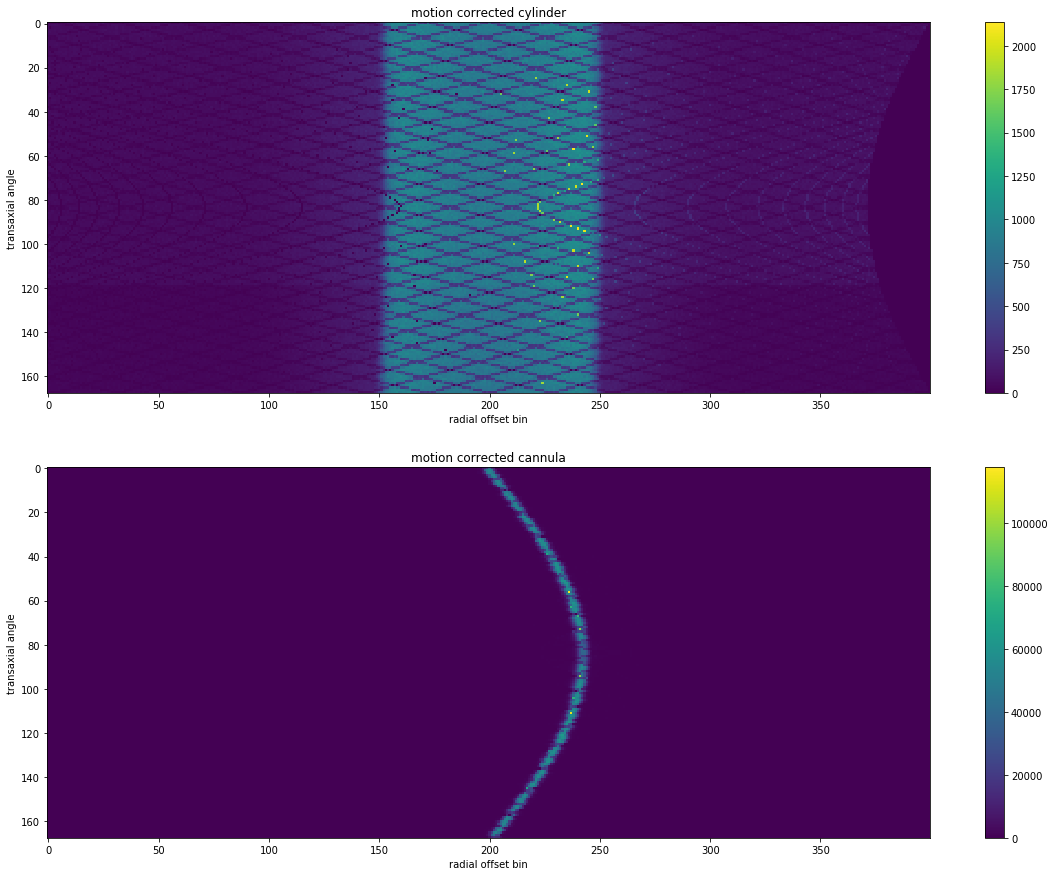

In [20]:
#check before saving and reconstructing
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    
    #im = ax.imshow(mc_sinograms[pkey][0,50])
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, :109], axis=(0,1)))
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, 600:], axis=(0,1)))
    im = ax.imshow(np.sum(mc_sinograms[pkey], axis=(0,1)))
    ax.set_ylabel("transaxial angle")
    ax.set_xlabel("radial offset bin")
    ax.set_title("motion corrected " +pkey )
    fig.colorbar(im, ax=ax)

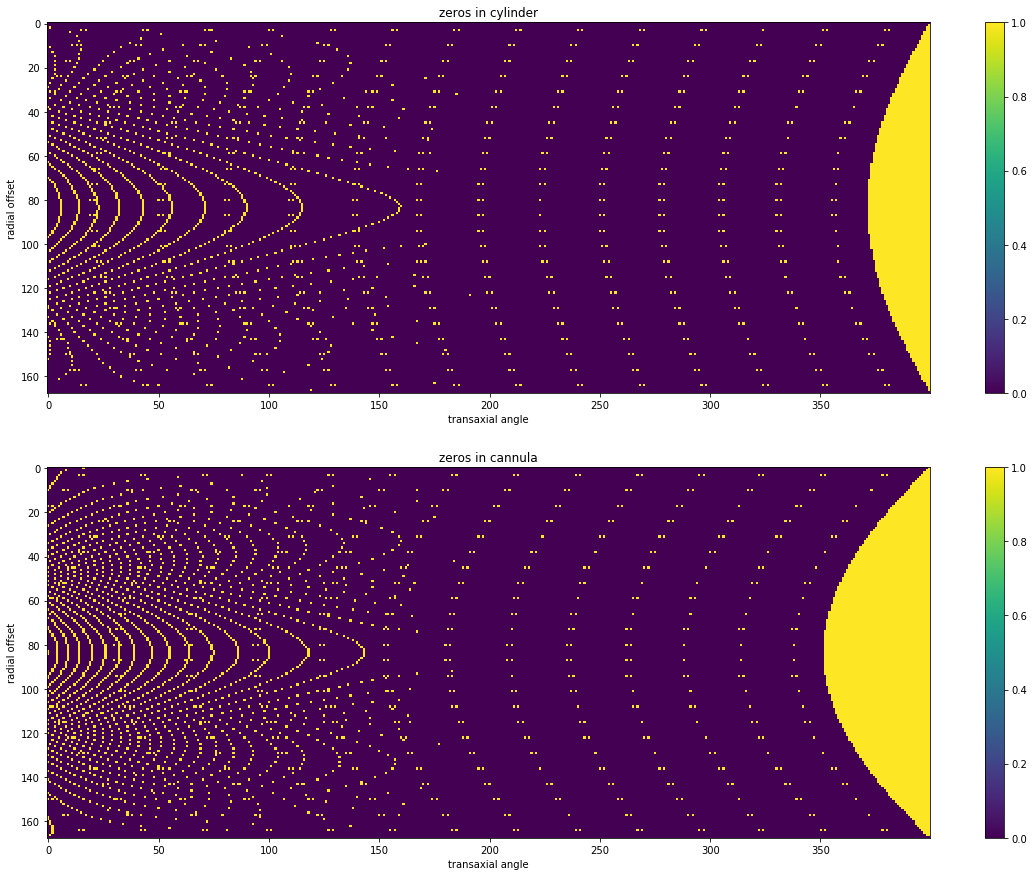

In [15]:
#check before saving and reconstructing
fig, axes = plt.subplots(nrows=2, figsize=(20,15))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    
    #im = ax.imshow(mc_sinograms[pkey][0,50])
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, :109], axis=(0,1)))
    #im = ax.imshow(np.sum(mc_sinograms[pkey][0:1, 600:], axis=(0,1)))
    im = ax.imshow(1*(np.sum(mc_sinograms[pkey], axis=(0,1)) == 0))
    ax.set_xlabel("transaxial angle")
    ax.set_ylabel("radial offset")
    ax.set_title("zeros in " +pkey )
    fig.colorbar(im, ax=ax)

In [16]:
ref_sinograms = kex_data.get_sinograms()

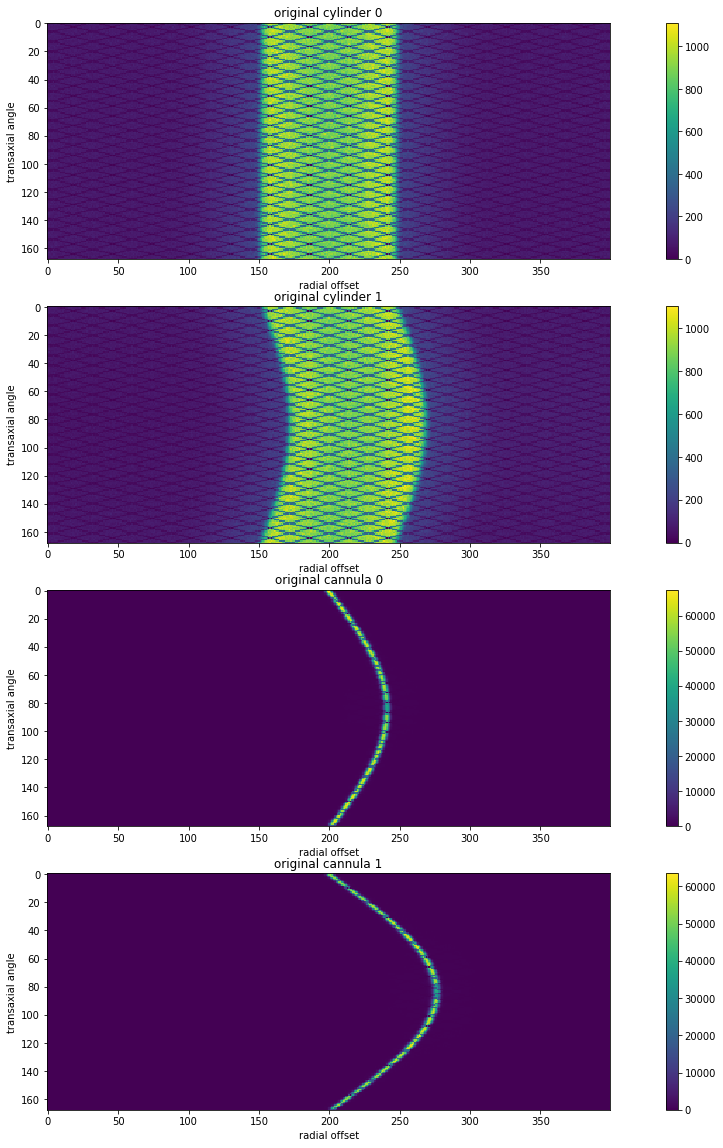

In [19]:
fig, axes = plt.subplots(nrows=4, figsize=(20,20))
for (dkey, sino), ax in zip(ref_sinograms.items(), axes.flatten()):
    im = ax.imshow(np.sum(sino, axis=(0,1)))
    ax.set_ylabel("transaxial angle")
    ax.set_xlabel("radial offset")
    ax.set_title("original " + dkey)
    fig.colorbar(im, ax=ax)

In [ ]:
import filefit as ff

In [ ]:
hdrs = kex_data.get_sino_hdrs()
mhdrs = kex_data.get_sino_mainhdrs()
for h,m in zip(hdrs, mhdrs):
    filling = [h,m]
    mc_dir = r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected"
    ff.prep_folder(mc_dir, filling)

In [ ]:
#account for 2 gates of data in gate 0 timewindow of 61 seconds
header_fix = True
if not header_fix:
    mc_sinograms = {k: v//2 for k, v in mc_sinograms.items()} #instead of double time in sinogram
else:
    header_paths = kex_data.get_sino_hdrs()
    header_paths = ff.refolder_paths(paths=header_paths, folder=mc_dir)
    for path in header_paths:
        with open(path, 'rt') as f:
            lines = f.readlines()
            for k, line in enumerate(lines):
                print(line[:-1])
                keys = ["!image duration (sec):=60", "%image duration from timing tags (msec):=60014"]
                for key in keys:
                    if key in line:
                        lines[k] = line.replace("60", str(2*60))
                        print("------to do: double time at k={}".format(k))
                        print(lines[k])
                        break
        with open(path, 'wt') as f:
            for line in lines:
                f.write(line)

In [ ]:
#save to ref
ref = 0
sino_paths = kex_data.get_sino_paths()
sino_paths = ff.refolder_paths(mc_dir, sino_paths)
sino_paths = dict(zip(kex_data.DATA_KEYS, sino_paths))
for pkey in kex_data.PHANTOM_KEYS:
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    output_path = sino_paths[dkey]
    print(output_path)
    with open(output_path, 'wb') as file:
        sino = mc_sinograms[pkey].astype('uint16')
        file.write(sino)

In [ ]:
import e7tools

In [ ]:
#reconstruct with e7tools
mc_mhdrs = ff.refolder_paths(mc_dir, kex_data.get_sino_mainhdrs())
mc_mhdrs = dict(zip(kex_data.DATA_KEYS, mc_mhdrs))
for pkey,dcr in zip(kex_data.PHANTOM_KEYS, kex_data.RECON_DCR[::2]):
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    image_path = mc_dir + "/"+pkey
    npath = kex_data.NORM_PATH
    print("return code", 
          e7tools.kex_recon(mc_mhdrs[dkey], npath, image_path, verbose=False, dcr=dcr))

In [ ]:
#get reconstructions
import filefit as ff
import os
vfiles = []
with os.scandir(mc_dir) as it:
    for entry in it:
        if entry.is_file() and entry.name.endswith('.v'):
            print("v file", entry.name)
            vfiles.append(entry.name)
vfiles = dict(zip(kex_data.PHANTOM_KEYS, vfiles[::-1]))
mc_recon = {k: ff.get_v_data(mc_dir+"/"+v) for k,v in vfiles.items()}

In [ ]:
import volume_view as vv
import importlib
importlib.reload(vv)
import visual
importlib.reload(visual)
def my_plot(img_dict, pos = [47,120,100], **imshowkwargs):
    nims = len(img_dict)
    fig, axes = plt.subplots(nrows=nims, ncols=3, figsize=(20, 7*nims))
    for (key,img), row in zip(img_dict.items(), axes):
        dimlabels = 'zyx'
        views = vv.plot_views(img, 
                      position=pos,
                      axes=row, 
                      dimlabels=dimlabels, 
                      img_title=key, **imshowkwargs)
        visual.same_colorbar(fig, views, row, **imshowkwargs)

In [ ]:
#my_plot(mc_recon, [47,120, 100], **{'clim':[0, 1600]})
my_plot(mc_recon, clim=[0,1200])

In [ ]:
importlib.reload(kex_data)
ref_v_recon = kex_data.get_v_data()
_,_, dicom_paths = kex_data.paths()
print(dicom_paths)
print(ref_v_recon.keys())

In [ ]:
ref_dict = {pkey: ref_v_recon[pkey+" 0"] for pkey in kex_data.PHANTOM_KEYS}
#my_plot(ref_dict, [47,120, 100], **{'clim':[0, 1600]})
my_plot(ref_dict,clim=[0,1600])